## Exploring Accenture Text data

### This analysis is structured into 4 part
- 1) Loading
- 2) Analysis 
- 4) Preporcessing
- 3) Model development and evaluation

In [8]:
#! pip install --user --upgrade tensorflow-gpu

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu
ERROR: No matching distribution found for tensorflow-gpu


In [1]:
#! pip install tensorflow==2.2

In [2]:
#!pip install tensorboard==2.2.0
#!pip install keras

In [6]:
import pandas as pd
import json
import os
import re
import numpy as np
import string 
from nltk.tokenize import RegexpTokenizer
import nltk
import math
import sys
from subprocess import call
from nltk import FreqDist
import sklearn as sk
import pickle
from collections import Counter
import requests
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from tensorflow import keras
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
import matplotlib as plt

#!pip install spacy
#!python -m spacy download en_core_web_sm

In [7]:
pwd()


'/Users/julia/Downloads'

In [8]:
review = []
for line in open('Beauty_5_50000.json', 'r'):
    review.append(json.loads(line))

In [9]:
df=pd.DataFrame(review)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   asin            50000 non-null  object
 1   helpful         50000 non-null  object
 2   overall         50000 non-null  int64 
 3   reviewText      50000 non-null  object
 4   reviewTime      50000 non-null  object
 5   reviewerID      50000 non-null  object
 6   reviewerName    49654 non-null  object
 7   summary         50000 non-null  object
 8   unixReviewTime  50000 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 3.4+ MB


## How are the classes (0-5) distributed ?

<AxesSubplot:>

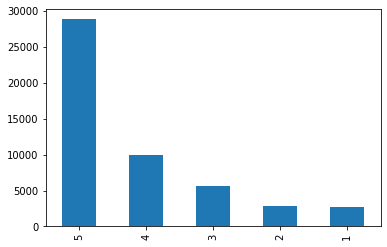

In [10]:
df.overall.value_counts().plot.bar() 

### class imbalance
but this might be skewed for the number of reviews (E.g having a few product with many positive reviews, and then a large amount with few but negative reviews)

In [11]:
df.overall.value_counts()

5    28842
4     9963
3     5681
2     2843
1     2671
Name: overall, dtype: int64

In [12]:
df.overall.median(), df.overall.mean()

(5.0, 4.18924)

In [13]:
len(df.asin.unique())

10926

In [14]:
len(df.reviewerID.unique())

19182

In [15]:
len(df.reviewerName.unique())

17023

### How are the number of reviews distributed across different products ? 

In [17]:
df.asin.value_counts().plot.bar(figsize=(80,20))

### Let's find out the average rating per product

In [18]:
dfsub =df.groupby('asin', as_index=False).agg({"overall": "mean"})
df = pd.merge(df, dfsub, how='outer', on='asin')
df.rename(columns={'overall_y': 'average_rating'}, inplace=True)

In [19]:
df.rename(columns={'overall_x': 'overall'}, inplace=True)

In [20]:
dfsub = df.drop_duplicates(subset=['asin'], keep='first')

In [21]:
dfsub['average_rating']=dfsub.average_rating.round(1)

/Users/julia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

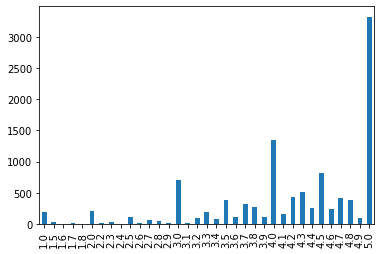

In [22]:
dfsub.average_rating.value_counts().sort_index().plot.bar() 

#### Analysis shows:
Reviews seem to be fairly distributed acorss products, but the class imbalance (between pos and neg reviews is sitll an issue going forward)

In [23]:
dfsub.groupby(['reviewerID', 'average_rating'])['asin'].count()

reviewerID             average_rating
A02155413BVL8D0G7X6DN  5.0               1
A029527620Q3SK5XW16RR  3.0               1
A03364251DGXSGA9PSR99  2.5               1
                       4.0               1
                       4.3               1
                                        ..
AZYN9RRLZUNVA          4.8               1
                       5.0               1
AZZ5ASC403N74          4.1               1
AZZT1ERHBSNQ8          4.5               1
AZZU6NXB8YJN9          4.0               1
Name: asin, Length: 10171, dtype: int64

### Data Preparation

### Since we have strong class imbalance, it makes sense to aggregate reviews.
Even though logically, we would group 5 star and 4 star reviews together, it wouldn't help the class imbalance as 1, 2 and 3 star reviews grouped are still to small. Hence, we will be aggregating 1, 2, 3 and 4 star reviews. With this approach, we train a classifier that is conservative which will not perform as well, since we can anticipate that the difference between a 4 star and 5 star reviews is difficult to detect just from the text

In [24]:
#create two labels, 0 corresponding to negative, 1 to positive.
df['label'] = 0
for x in df.index:
    if df.loc[x, 'overall'] > 3:
        df.loc[x, 'label'] =  1       

<AxesSubplot:>

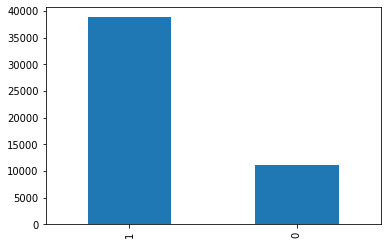

In [25]:
df.label.value_counts().plot.bar() 

In [26]:
df.label.value_counts()

1    38805
0    11195
Name: label, dtype: int64

### Review length matters, 
Since we are working with text. To more text there is to describe positive or negative review, the better the classifer can be trained. 

In [28]:
df['length'] = df['reviewText'].apply(len)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

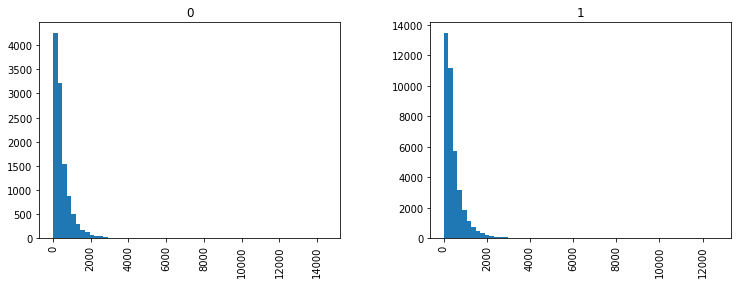

In [29]:
df.hist(column='length', by='label', bins=60,figsize=(12,4))

### Building a classifier

Classification models that are built based on the review text as the independent variable to predict whether a customer recommends a product. 
semantic parsing where the word sequence, word usage as noun or verb, hierarchial word structure etc matters. 
Bag of words where all the words are analysed as a single token and order does not matter


In [30]:
#removing punctuation
def remove_punc(text):
    nopunc = ([x for x in text if x not in string.punctuation])
    nopunc = ''.join(nopunc)
    return nopunc

In [31]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [32]:
df['reviews'] = df['reviewText'].apply(lambda x: remove_punc(x))

In [33]:
df['reviews'] = df['reviews'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [34]:
#removing stopwords (such as I, and)
def stop_words(text):
    words = [x for x in text if x not in stopwords.words('english')]
    #words = ' '.join(words)
    return words

In [35]:
df['reviews'] = df['reviews'].apply(lambda x: stop_words(x))

In [36]:
#We can try to either use a stemmer or a lemmatizer. Stemming is more aggresive, but may miss relationships such as feel and felt
import nltk
def stem_with_porter(words):
    porter = nltk.PorterStemmer()
    new_words = [porter.stem(w) for w in words]
    new_words = ' '.join(new_words)
    return new_words

In [22]:
lemmatizer = WordNetLemmatizer()

def word_lemma(text):
    lemma = [lemmatizer.lemmatize(i) for i in text]
    lemma = ' '.join(lemma)
    return lemma

In [23]:
df['reviews'] = df['reviews'].apply(lambda x: stem_with_porter(x))

In [37]:
df

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,average_rating,label,length,reviews
0,9759091062,"[0, 0]",3,I bought this product to get rid of the dark s...,"12 27, 2013",A30IP88QK3YUIO,Amina Bint Ibraheem,Its alright,1388102400,3.5,0,253,"[bought, product, get, rid, dark, spots, face,..."
1,9759091062,"[0, 1]",5,"I bought this product about 3 months ago, I fi...","01 23, 2014",A1EVGDOTGFZOSS,"Jessica ""Anarchykisses""",This works,1390435200,3.5,1,338,"[bought, product, 3, months, ago, finished, tu..."
2,9759091062,"[0, 0]",1,This gell did nothing at all. I religiously pu...,"01 11, 2014",AP5WTCMP6DTRV,Layla B,Does nothing,1389398400,3.5,0,121,"[gell, nothing, religiously, put, specific, ar..."
3,9759091062,"[0, 1]",5,i got this to get rid of a scar and it did jus...,"02 18, 2014",A21IM16PQWKVO5,mdub9922,it works,1392681600,3.5,1,207,"[got, get, rid, scar, looking, remove, discolo..."
4,9788072216,"[24, 24]",5,I haven't been a big fan of Prada's fragrances...,"09 19, 2011",A1QV5IH6HDRN0L,armygirl,Love the smell of this!,1316390400,5.0,1,485,"[havent, big, fan, pradas, fragrances, years, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,B00L6Q3BH6,"[10, 10]",4,I feel like I could pierce a man's soul while ...,"04 24, 2014",A12UT32YCU0WT0,Marie Esther,Such a beautiful color,1398297600,4.0,1,742,"[feel, like, could, pierce, mans, soul, wearin..."
49996,B00L6Q3BH6,"[0, 0]",5,I love this like I love all limecrimemakeup pr...,"05 8, 2014",A242EJZ1C5N4LM,Sherry,love velviteens,1399507200,4.0,1,126,"[love, like, love, limecrimemakeup, products, ..."
49997,B00LCEROA2,"[0, 0]",5,I love to mix this rosehip oil with my other e...,"07 12, 2014",A2W37S6VC464WK,Cameron,Love This!,1405123200,5.0,1,142,"[love, mix, rosehip, oil, essential, oils, boo..."
49998,B00LCEROA2,"[0, 0]",5,Alot of product that has rosehip oil is costly...,"07 3, 2014",A30WU937PCLEG1,Peter,Works Great!,1404345600,5.0,1,421,"[alot, product, rosehip, oil, costly, dr, song..."


### The imbalance of classes
Can for example be tackeled by cutting off a certain percentage of the majority class. We could also cluster the 5 star reviews and remove very similar reviews. Howver, this might introduce bias to the model. Thus, for now we will cut off 50% of the majority class, which still results in an imbalance of classes but is less sever

In [38]:
df1 = df[df['overall'] == 5].sample(frac = 0.5)

In [39]:
indicies = df1.index.to_list()   
df_short=df.drop(df.index[indicies])

In [40]:
len(df), len(df_short)

(50000, 35579)

<AxesSubplot:>

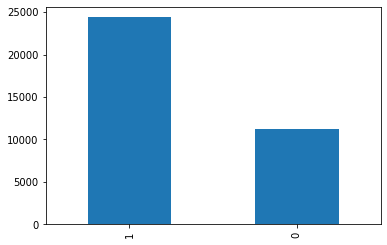

In [41]:
df_short.label.value_counts().plot.bar() 

In [42]:
df_short.reset_index()

,index,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,average_rating,label,length,reviews
0,0,9759091062,"[0, 0]",3,I bought this product to get rid of the dark s...,"12 27, 2013",A30IP88QK3YUIO,Amina Bint Ibraheem,Its alright,1388102400,3.5,0,253,"[bought, product, get, rid, dark, spots, face,..."
1,1,9759091062,"[0, 1]",5,"I bought this product about 3 months ago, I fi...","01 23, 2014",A1EVGDOTGFZOSS,"Jessica ""Anarchykisses""",This works,1390435200,3.5,1,338,"[bought, product, 3, months, ago, finished, tu..."
2,2,9759091062,"[0, 0]",1,This gell did nothing at all. I religiously pu...,"01 11, 2014",AP5WTCMP6DTRV,Layla B,Does nothing,1389398400,3.5,0,121,"[gell, nothing, religiously, put, specific, ar..."
3,3,9759091062,"[0, 1]",5,i got this to get rid of a scar and it did jus...,"02 18, 2014",A21IM16PQWKVO5,mdub9922,it works,1392681600,3.5,1,207,"[got, get, rid, scar, looking, remove, discolo..."
4,6,9790790961,"[0, 0]",5,Got this product and I never heard of this so ...,"09 8, 2013",A3TYR1ALBZ2EU9,Mananagirl6,My new smell!,1378598400,4.0,1,284,"[got, product, never, heard, took, chance, got..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35574,49989,B00L5KTZ0K,"[0, 0]",5,I have been taking this for about a week and I...,"07 22, 2014",A3JI7QRZO1QG8X,Joyce M. Davidson,It's been about a week so far,1405987200,5.0,1,222,"[taking, week, feel, really, good, face, glowi..."
35575,49994,B00L6Q3BH6,"[5, 5]",3,"Because of all the hype, I decided to try the ...","05 24, 2014",A1PIJ1IUG6S3SQ,christine,superb pigmentation and matte but extremely dr...,1400889600,4.0,0,1207,"[hype, decided, try, velvetines, despite, best..."
35576,49995,B00L6Q3BH6,"[10, 10]",4,I feel like I could pierce a man's soul while ...,"04 24, 2014",A12UT32YCU0WT0,Marie Esther,Such a beautiful color,1398297600,4.0,1,742,"[feel, like, could, pierce, mans, soul, wearin..."
35577,49997,B00LCEROA2,"[0, 0]",5,I love to mix this rosehip oil with my other e...,"07 12, 2014",A2W37S6VC464WK,Cameron,Love This!,1405123200,5.0,1,142,"[love, mix, rosehip, oil, essential, oils, boo..."


### With CountVectorizer,
we are converting raw text to a numerical vector representation of words and n-grams. This makes it easy to directly use this representation as features (signals) in Machine Learning tasks such as for text classification and clustering. With the TFID transformer, we invert the importance of words, depending on the frequency in all documents.

In [31]:
X = df_short['reviews']
y = df_short['overall']  

In [32]:
vectorizer = CountVectorizer(max_features = 6000, ngram_range=(1,3))

data_features = vectorizer.fit_transform(X)
tfidf_transformer = TfidfTransformer()
data_features_tfidf = tfidf_transformer.fit_transform(data_features)
data_mat = data_features_tfidf.toarray()

In [33]:
ar=data_mat[4]
ar

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
df_short.reviews[4]

'havent big fan prada fragranc year absolut fell love sweet candylik scent perfum smell like sweet decad caramel tone vanilla im sure els smell great although must say seller ask way high price bottl could get 27 oz bottl around price neiman marcu 17 oz around 80 prefer smaller bottl'

### Data Splitting
We use a 70/ 30 split, where we train on 70% of the entire dataset and test on 30%

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_mat, y,test_size=0.3,random_state=101)

In [36]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="none")
clf.fit(X_train, y_train)
## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_
## Get predictions on training and test data
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
## Compute errors
errs_train = np.sum((preds_train > 0.0) != (y_train > 0.0))
errs_test = np.sum((preds_test > 0.0) != (y_test > 0.0))
print("Training error: ", float(errs_train)/len(y_train))
print("Test error: ", float(errs_test)/len(y_test))

Training error:  0.0
Test error:  0.0


### Evaluation
Let' evaluate the logistic regression classifier and see which words are most important per class


In [37]:
print(confusion_matrix(y_test,preds_test))
print(classification_report(y_test,preds_test))

[[ 344   99  121   94  156]
 [ 155  128  269  189  155]
 [  64  115  565  586  379]
 [  31   40  316 1321 1211]
 [  30   24  124  684 3474]]
              precision    recall  f1-score   support

           1       0.55      0.42      0.48       814
           2       0.32      0.14      0.20       896
           3       0.41      0.33      0.36      1709
           4       0.46      0.45      0.46      2919
           5       0.65      0.80      0.72      4336

    accuracy                           0.55     10674
   macro avg       0.48      0.43      0.44     10674
weighted avg       0.52      0.55      0.53     10674



In [38]:
## Convert vocabulary into a list to see the most important words
vocab = np.array([x[0] for x in sorted(vectorizer.vocabulary_.items(), key=lambda x:x[1])])
vocab

array(['10', '10 day', '10 minut', ..., 'zipper', 'zit', 'zone'],
      dtype='<U25')

In [39]:
inds = np.argsort(w)
inds

array([3056, 2091, 4741, ..., 4296, 5089, 2467])

In [40]:
inds = np.argsort(w)
## Words with large positive values
pos_inds = inds[0:50]
print("Highly positive words: ")
print([str(x) for x in list(vocab[pos_inds])])
## Words with large negative values
neg_inds = inds[-49:-1]
print("Highly negative words: ")
print([str(x) for x in list(vocab[neg_inds])])

Highly positive words: 
['love', 'great', 'soft', 'nice', 'without', 'best', 'bit', 'quickli', 'easi', 'littl', 'price', 'though', 'perfect', 'one best', 'last', 'awesom', 'knot', 'havent', 'well', 'work great', 'help', 'great product', 'excel', 'wonder', 'job', 'need', 'work well', 'amaz', 'brush great', 'enjoy', 'alway', 'husband', 'okay', 'fine', 'everi', 'smooth', 'iron', 'night', 'today', 'heart', 'mirror', 'compliment', 'ive', 'silki', 'keep', 'appreci', 'beauti', 'goe', 'drop', 'happi']
Highly negative words: 
['fail', 'mayb', 'rip', 'imposs', 'thigh', 'wish could', 'stop use', 'stick', 'left', 'cheap', 'formul', 'fell', 'put face', 'broke', 'skin tri', 'junk', 'tri use', 'poor', 'absolut', 'crap', 'dont buy', 'money', 'iti', 'refund', 'caus', 'advertis', 'liter', 'new product', 'one star', 'unfortun', 'useless', 'doesnt work', 'never', 'check', 'noth', 'good review', 'toss', 'disappoint', 'aw', 'gross', 'even', 'return', 'worst', 'threw', 'wast', 'garbag', 'runni', 'terribl']


In [44]:
stop_set = {'doesnt', 'review'}

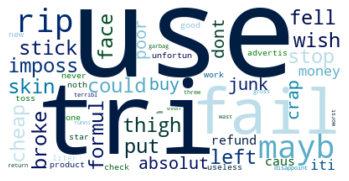

In [45]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_set, background_color="White", colormap="ocean_r",
               max_font_size=150, random_state=42)
#plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(vocab[neg_inds])))
pyplot.imshow(wc, interpolation="bilinear")
pyplot.axis("off")    
pyplot.show()

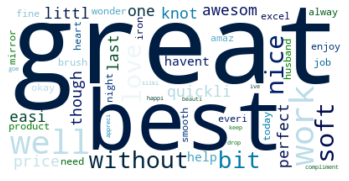

In [46]:
from wordcloud import WordCloud
wc = WordCloud(stopwords=stop_set, background_color="White", colormap="ocean_r",
               max_font_size=150, random_state=42)
#plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(" ".join(list(vocab[pos_inds])))
pyplot.imshow(wc, interpolation="bilinear")
pyplot.axis("off")    
pyplot.show()

### Classifier with two classes
Let' use only two classes instead, positive and negative

In [48]:
X = df_short['reviews']
y = df_short['label']  

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data_mat, y,test_size=0.3,random_state=101)

In [50]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="none")
clf.fit(X_train, y_train)
## Pull out the parameters (w,b) of the logistic regression model
w = clf.coef_[0,:]
b = clf.intercept_
## Get predictions on training and test data
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
## Compute errors
errs_train = np.sum((preds_train > 0.0) != (y_train > 0.0))
errs_test = np.sum((preds_test > 0.0) != (y_test > 0.0))
print("Training error: ", float(errs_train)/len(y_train))
print("Test error: ", float(errs_test)/len(y_test))

Training error:  0.13001405340293115
Test error:  0.18933857972643808


In [51]:
print(confusion_matrix(y_test,preds_test))
print(classification_report(y_test,preds_test))

[[2362 1057]
 [ 964 6291]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      3419
           1       0.86      0.87      0.86      7255

    accuracy                           0.81     10674
   macro avg       0.78      0.78      0.78     10674
weighted avg       0.81      0.81      0.81     10674



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.865


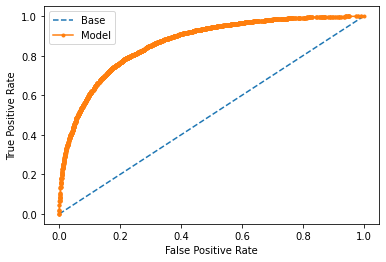

In [211]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Model: f1=0.864 auc=0.927


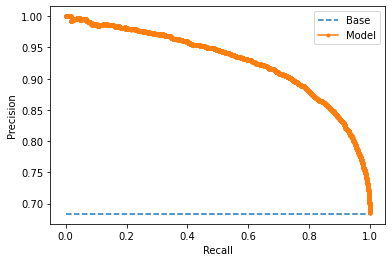

In [212]:
# precision-recall curve and f1
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, preds_test), auc(lr_recall, lr_precision)
# summarize scores
print('Model: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Base')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Model')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Neural Network with two labels only

In [46]:
y = df_short['label']
X = df_short['reviews']

In [47]:
max_review_length = 200

tokenizer = Tokenizer(num_words= 10000,  #max no. of unique words to keep
                      #filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True) #convert to lower case)

#n_grams
tokenizer.fit_on_texts(X)
words_to_index = tokenizer.word_index

In [48]:
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen= max_review_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (35579, 200)


In [49]:
Y=pd.get_dummies(y).values
Y

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [59]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [60]:
from keras.utils import to_categorical
y_test = to_categorical(y_test)

In [53]:
#!pip install tornado==6.1.0
#!pip install pandas==1.1.0
#!pip install -U ipython==7.20

In [63]:
EMBEDDING_DIM = 200
model = Sequential()
model.add(Embedding(10000, EMBEDDING_DIM, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(250, dropout=0.2,return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 200)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 250)          451000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               140400    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 2,591,602
Trainable params: 2,591,602
Non-trainable params: 0
_________________________________________________________________
None


In [155]:
#import tensorflow as tf

In [142]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [144]:
if tf.config.experimental.list_physical_devices('GPU'):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])

In [64]:
epochs = 4
batch_size = 40
model.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_split=0.1)

Epoch 1/4
561/561 [==============================] - 336s 592ms/step - loss: 0.5230 - accuracy: 0.7493 - val_loss: 0.4129 - val_accuracy: 0.8226
Epoch 2/4
561/561 [==============================] - 314s 559ms/step - loss: 0.3491 - accuracy: 0.8529 - val_loss: 0.4134 - val_accuracy: 0.8105
Epoch 3/4
561/561 [==============================] - 309s 551ms/step - loss: 0.2737 - accuracy: 0.8903 - val_loss: 0.4417 - val_accuracy: 0.8029
Epoch 4/4
561/561 [==============================] - 316s 564ms/step - loss: 0.2184 - accuracy: 0.9167 - val_loss: 0.4660 - val_accuracy: 0.8033


In [65]:
loss, acc = model.evaluate(X_test, y_test, verbose=2,
                            batch_size=batch_size)
print(f"loss: {loss}")
print(f"Validation accuracy: {acc}")

267/267 - 36s - loss: 0.4864 - accuracy: 0.7883
loss: 0.4864031970500946
Validation accuracy: 0.7882705926895142


### Pretrained word embeddings word2vec
Word2Vec is a more recent model that embeds words in a lower-dimensional vector space using a shallow neural network. The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings. For example, strong and powerful would be close together and strong and Paris would be relatively far.


In [66]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

    return word_to_vec_map

In [67]:
#load the whole embedding into memory
word_to_vec_map = read_glove_vector('glove.6B.100d.txt')

maxLen = 200

In [68]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [117]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(250, dropout=0.2,return_sequences=True))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          5165700   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 250)          351000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               140400    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 5,657,302
Trainable params: 491,602
Non-trainable params: 5,165,700
_________________________________________________________________
None


In [118]:
epochs = 4
batch_size = 40
model2.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_split=0.1)

Train on 22414 samples, validate on 2491 samples
Epoch 1/4
22414/22414 [==============================] - 860s 38ms/step - loss: 0.5916 - accuracy: 0.6968 - val_loss: 0.5658 - val_accuracy: 0.7029
Epoch 2/4
22414/22414 [==============================] - 842s 38ms/step - loss: 0.5488 - accuracy: 0.7197 - val_loss: 0.5315 - val_accuracy: 0.7338
Epoch 3/4
22414/22414 [==============================] - 927s 41ms/step - loss: 0.5246 - accuracy: 0.7369 - val_loss: 0.5661 - val_accuracy: 0.7118
Epoch 4/4
22414/22414 [==============================] - 842s 38ms/step - loss: 0.5177 - accuracy: 0.7428 - val_loss: 0.4989 - val_accuracy: 0.7539


In [119]:
loss, acc = model2.evaluate(X_test, y_test, verbose=2,
                            batch_size=batch_size)
print(f"loss: {loss}")
print(f"Validation accuracy: {acc}")

loss: 0.48660132759672126
Validation accuracy: 0.7653176188468933


### Pretrained word embeddings not stemmatized

In [69]:
model3 = Sequential()
model3.add(embedding_layer)
model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(250, dropout=0.2,return_sequences=True))
model3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(2, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 100)          6230900   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 200, 250)          351000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               140400    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 6,722,502
Trainable params: 491,602
Non-trainable params: 6,230,900
_________________________________________________________________
None


In [70]:
epochs = 6
batch_size = 40
model3.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_split=0.1)

Epoch 1/6
561/561 [==============================] - 281s 494ms/step - loss: 0.5928 - accuracy: 0.6880 - val_loss: 0.5351 - val_accuracy: 0.7090
Epoch 2/6
561/561 [==============================] - 273s 487ms/step - loss: 0.5208 - accuracy: 0.7400 - val_loss: 0.4859 - val_accuracy: 0.7768
Epoch 3/6
561/561 [==============================] - 265s 472ms/step - loss: 0.4915 - accuracy: 0.7590 - val_loss: 0.4651 - val_accuracy: 0.7716
Epoch 4/6
561/561 [==============================] - 276s 493ms/step - loss: 0.4719 - accuracy: 0.7713 - val_loss: 0.4611 - val_accuracy: 0.7808
Epoch 5/6
561/561 [==============================] - 266s 474ms/step - loss: 0.4610 - accuracy: 0.7796 - val_loss: 0.4633 - val_accuracy: 0.7860
Epoch 6/6
561/561 [==============================] - 270s 482ms/step - loss: 0.4452 - accuracy: 0.7929 - val_loss: 0.4471 - val_accuracy: 0.7937


In [71]:
loss, acc = model3.evaluate(X_test, y_test, verbose=2,
                            batch_size=batch_size)
print(f"loss: {loss}")
print(f"Validation accuracy: {acc}")

267/267 - 30s - loss: 0.4447 - accuracy: 0.7929
loss: 0.44467347860336304
Validation accuracy: 0.7928611636161804


### Model tuning

In [72]:
from sklearn.utils import class_weight

In [102]:
y = df_short['label']
X = df_short['reviews']

In [103]:
max_review_length = 1000

tokenizer = Tokenizer(num_words= 10000,  #max no. of unique words to keep
                      #filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True) #convert to lower case)

tokenizer.fit_on_texts(X)
words_to_index = tokenizer.word_index

In [82]:
word_to_vec_map = read_glove_vector('glove.6B.100d.txt')

max_review_length = 1000

In [104]:
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X, maxlen= max_review_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (35579, 1000)


In [84]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=max_review_length, weights = [emb_matrix], trainable=False)

In [105]:
Y=pd.get_dummies(y).values
Y

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [95]:
#class_weight = class_weight = {0: 1., 1: 50., 2: 2.}

AttributeError: 'numpy.ndarray' object has no attribute 'compute_class_weight'

In [107]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

from keras.utils import to_categorical
y_test = to_categorical(y_test)

In [109]:
EMBEDDING_DIM = 1000
model4 = Sequential()
model4.add(Embedding(10000, EMBEDDING_DIM, input_length = X.shape[1]))
model4.add(SpatialDropout1D(0.2))
model4.add(LSTM(250, dropout=0.2,return_sequences=True))
model4.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(2, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 1000)        10000000  
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 1000)        0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1000, 250)         1251000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               140400    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 202       
Total params: 11,391,602
Trainable params: 11,391,602
Non-trainable params: 0
_________________________________________________________________
None


In [110]:
epochs = 10
batch_size = 40
model4.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_split=0.1)

Epoch 1/10
561/561 [==============================] - 2768s 5s/step - loss: 0.5114 - accuracy: 0.7544 - val_loss: 0.4516 - val_accuracy: 0.7989
Epoch 2/10
561/561 [==============================] - 2765s 5s/step - loss: 0.3304 - accuracy: 0.8608 - val_loss: 0.4152 - val_accuracy: 0.8214
Epoch 3/10
561/561 [==============================] - 2738s 5s/step - loss: 0.2473 - accuracy: 0.9015 - val_loss: 0.4479 - val_accuracy: 0.8049
Epoch 4/10
561/561 [==============================] - 2861s 5s/step - loss: 0.1666 - accuracy: 0.9374 - val_loss: 0.5722 - val_accuracy: 0.7933
Epoch 5/10
561/561 [==============================] - 2919s 5s/step - loss: 0.1118 - accuracy: 0.9596 - val_loss: 0.6481 - val_accuracy: 0.7921
Epoch 6/10
561/561 [==============================] - 3086s 6s/step - loss: 0.0641 - accuracy: 0.9792 - val_loss: 0.8948 - val_accuracy: 0.7868
Epoch 7/10
561/561 [==============================] - 3028s 5s/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.9700 - val_accuracy:

In [111]:
loss, acc = model4.evaluate(X_test, y_test, verbose=2,
                            batch_size=batch_size)
print(f"loss: {loss}")
print(f"Validation accuracy: {acc}")

267/267 - 306s - loss: 1.2396 - accuracy: 0.7653
loss: 1.2395814657211304
Validation accuracy: 0.7653176188468933


In [ ]:
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon